# Embedded ML - Lab 2.2: TensorFlow Lite

In this lab you will learn the basics of TensorFlow Lite, a complement of TensorFlow that allows you to optimize and run models on constrained devices. It provides a much lighter runtime than TensorFlow but it only supports a subset of the tools available in full TensorFlow.

In this lab you might be given some helper functions but you are expected to write most of the code and be able to explain it at a high level of abstraction and also to modify any part of it.

### Learning outcomes


* Explain the basic concepts associated with TensorFlow Lite
* Develop applications following the basic TensorFlow Lite workflow
* Implement post-training quantization using TensorFlow Lite tools

### TensorFlow Lite workflow
After having built a TensorFlow model, you can convert it to the TensorFlow Lite representation. Then you can run it with the TensorFlow Lite interpreter on your development environment before exporting it and copying it to the target device.

To run the model with TensorFlow Lite you should load the model to the TensorFlow Lite interpreter, allocate the input/output tensors, pass the input data and finally run inference. Notice that TensorFlow Lite API calls are different from those of TensorFlow.

In this part of the assignment, you should create and train a simple model (e.g. a one-neuron network) with TensorFlow and then save it. Then follow the TensorFlow Lite workflow until you are able to run inference and validate the outputs.

In [1]:
#### TENSORFLOW BASIC WORKFLOW
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2025-05-27 15:07:05.932895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 15:07:05.936308: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 15:07:05.945242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748358425.959480  102084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748358425.964043  102084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748358425.976293  102084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin


### Explanation of the XOR Model Creation and Training

1. **Model Creation**:
    - A sequential model is created using `keras.Sequential`.
    - The first layer is a dense layer with 2 neurons, ReLU activation, and an input shape of `(2,)` (representing the two inputs for XOR).
    - The second layer is a dense layer with 1 neuron and a sigmoid activation function, which outputs a value between 0 and 1.

2. **Model Compilation**:
    - The model is compiled with the Adam optimizer, binary cross-entropy loss (suitable for binary classification), and accuracy as the evaluation metric.

3. **Data Preparation**:
    - Training data (`x_train`) consists of all possible combinations of binary inputs for XOR: `[0, 0], [0, 1], [1, 0], [1, 1]`.
    - Corresponding labels (`y_train`) represent the XOR outputs: `[0], [1], [1], [0]`.

4. **Model Training**:
    - The model is trained on the data for 500 epochs. Increasing the epochs ensures better learning for this simple problem.

5. **Model Evaluation**:
    - The model is evaluated on the same XOR dataset (`x_test` and `y_test`), and the accuracy is printed.

6. **Predictions**:
    - The model predicts outputs for the test inputs, and the predictions are printed alongside the actual values.

7. **Model Saving**:
    - The trained model is saved to a file named `xor_model.keras` for later use.


In [2]:

# Create the model for XOR
model = keras.Sequential([
    layers.Dense(2, activation='relu', input_shape=(2,)),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate some data
x_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# Train the model
y_train = np.array([[0], [1], [1], [0]])
model.fit(x_train, y_train, epochs=500, verbose=0)  # Increased epochs for better training


# Evaluate the model
x_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_test = np.array([[0], [1], [1], [0]])
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy:.4f}")

# Print the predictions
predictions = model.predict(x_test)
print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"Input: {x_test[i]}, Predicted: {pred}, Actual: {y_test[i]}")


# Save the model to a file
model.save('xor_model.keras')


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-27 15:07:08.704534: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Test accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions:
Input: [0 0], Predicted: [0.4679954], Actual: [0]
Input: [0 1], Predicted: [0.5453336], Actual: [1]
Input: [1 0], Predicted: [0.5354951], Actual: [1]
Input: [1 1], Predicted: [0.4648828], Actual: [0]



#### TENSORFLOW LITE BASIC WORKFLOW

1. **Load the XOR Model**:
    - The pre-trained XOR model is loaded from the file `xor_model.keras` using `tf.keras.models.load_model`.

2. **Convert the Model to TensorFlow Lite**:
    - The loaded model is passed to `tf.lite.TFLiteConverter.from_keras_model` to create a TensorFlow Lite converter.
    - The `convert()` method is called on the converter to generate the TensorFlow Lite model.

3. **Save the TensorFlow Lite Model**:
    - The converted TensorFlow Lite model is saved to a file named `xor_model.tflite` using the `pathlib` library.
    - The `write_bytes` method writes the model to the file and returns the size of the file in bytes, which is stored in the variable `write_file`.

In [3]:
#### TENSORFLOR LITE BASIC WORKFLOW

# Load model of the XOR
model = tf.keras.models.load_model('xor_model.keras')

# Convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Save TF Lite model to a file
import pathlib
tflite_model_path = pathlib.Path('xor_model.tflite')
write_file = tflite_model_path.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyt_mhu6t/assets


INFO:tensorflow:Assets written to: /tmp/tmpyt_mhu6t/assets


Saved artifact at '/tmp/tmpyt_mhu6t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  123646289417168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646289425040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646289424848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646289424656: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1748358441.645349  102084 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748358441.645375  102084 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-27 15:07:21.645670: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyt_mhu6t
2025-05-27 15:07:21.646057: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-27 15:07:21.646064: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpyt_mhu6t
I0000 00:00:1748358441.648505  102084 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-05-27 15:07:21.648918: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-27 15:07:21.662452: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpyt_mhu6t
2025-05-27 15:07:21.666971: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 


### Explanation: Setting up Input/Output Tensors

The line `interpreter = tf.lite.Interpreter(model_content=tflite_model)` initializes a TensorFlow Lite interpreter for the given TensorFlow Lite model. Here's what to do next:

1. **Allocate Tensors**:
    - Call `interpreter.allocate_tensors()` to allocate memory for the model's input and output tensors.

2. **Retrieve Input/Output Details**:
    - Use `interpreter.get_input_details()` to get information about the input tensor(s), such as shape, data type, and index.
    - Use `interpreter.get_output_details()` to get similar information about the output tensor(s).

3. **Set Input Data**:
    - Prepare the input data in the format and shape expected by the model (e.g., reshape or normalize if necessary).
    - Use `interpreter.set_tensor(input_details[0]['index'], input_data)` to set the input tensor.

4. **Run Inference**:
    - Call `interpreter.invoke()` to execute the model and perform inference.

5. **Retrieve Output Data**:
    - Use `interpreter.get_tensor(output_details[0]['index'])` to fetch the output tensor after inference.


In [ ]:
# Set up input/output tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)


In [5]:
!pip install ai-edge-litert
from ai_edge_litert.interpreter import Interpreter
interpreter = Interpreter(model_path=tflite_model_path)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
#Allocate tensors on the interpreter
interpreter.allocate_tensors()

# Set input values and output memory 
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)

print("TF Lite Predictions:")
def new_func(output_data):
    return int(output_data[0])

correct_predictions = 0

for i, single_input in enumerate(test_input):
    # Reshape input to match the expected shape (batch size of 1)
    single_input = single_input.reshape(1, -1)
    interpreter.set_tensor(input_details[0]['index'], single_input)

    # Run inference
    interpreter.invoke()

    # Get outputs
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(f"Input: {single_input[0]}, Predicted: {new_func(np.round(output_data))}, Actual: {y_test[i][0]}")

    # Check if the prediction is correct
    if np.round(output_data) == y_test[i][0]:
        correct_predictions += 1

# Accuracy
accuracy = correct_predictions / len(test_input)
print(f"TF Lite Model Accuracy: {accuracy:.4f}")

    

TF Lite Predictions:
Input: [0. 0.], Predicted: 0, Actual: 0
Input: [0. 1.], Predicted: 1, Actual: 1
Input: [1. 0.], Predicted: 1, Actual: 1
Input: [1. 1.], Predicted: 0, Actual: 0
TF Lite Model Accuracy: 1.0000


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/tmp/ipykernel_102084/638531425.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(output_data[0])


### Vision model with TensorFlow Lite

In this part of the assignment, you should import a small pre-trained model for a vision application that takes at most 1 MB. Then you should follow the TensorFlow Lite workflow until you are able to run inference and obtain the same results as with TensorFlow.

In [7]:
# Load the model ccn_model.keras
model_cnn = tf.keras.models.load_model('cnn_model.keras')
# Convert model to TF Lite
converter_cnn = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
tflite_model_cnn = converter_cnn.convert()

# Save TF Lite model to a file
tflite_model_cnn_path = pathlib.Path('ccn_model.tflite')
write_file_cnn = tflite_model_cnn_path.write_bytes(tflite_model_cnn)

# Set up input/output tensors
interpreter_cnn = Interpreter(model_path=tflite_model_cnn_path)
interpreter_cnn.allocate_tensors()
# Set input values and output memory
input_details_cnn = interpreter_cnn.get_input_details()
output_details_cnn = interpreter_cnn.get_output_details()


INFO:tensorflow:Assets written to: /tmp/tmpiba4tk13/assets


INFO:tensorflow:Assets written to: /tmp/tmpiba4tk13/assets


Saved artifact at '/tmp/tmpiba4tk13'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  123646274321680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646274320144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138582224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138584528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138585296: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1748358443.212640  102084 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748358443.212658  102084 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-27 15:07:23.212817: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpiba4tk13
2025-05-27 15:07:23.213241: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-27 15:07:23.213249: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpiba4tk13
2025-05-27 15:07:23.216985: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-27 15:07:23.240639: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpiba4tk13
2025-05-27 15:07:23.247819: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 35006 microseconds.



### Loading and Preprocessing the MNIST Fashion Dataset

1. **Dataset Loading**:
    - The MNIST Fashion dataset is loaded using `keras.datasets.fashion_mnist`.
    - This dataset contains grayscale images of size 28x28 representing 10 classes of fashion items (e.g., shirts, shoes, bags).

2. **Splitting the Dataset**:
    - The dataset is split into training (`x_train`, `y_train`) and testing (`x_test`, `y_test`) sets.

3. **Normalization**:
    - The pixel values of the test images (`x_test`) are normalized by dividing by 255.0 to scale them to the range [0, 1]. This helps improve model performance during inference.

4. **Data Type Conversion**:
    - The normalized test images (`x_test`) are converted to `float32` for compatibility with TensorFlow Lite models.
    - The test labels (`y_test`) are converted to `int32` to match the expected data type for classification tasks.

5. **Subset Selection**:
    - Only the first 100 samples from the test set are selected for testing to reduce computational overhead.

6. **Memory Optimization**:
    - The training data (`x_train`, `y_train`) is deleted using `del` to free up memory, as it is not needed for this testing workflow.

In [8]:
#Load a test dataset MNIST Fashion (Only for testing)
mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test / 255.0
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

# Only use 100 samples for testing
x_test = x_test[:100]
y_test = y_test[:100]

# Free memory of x_train and y_train
del x_train
del y_train

In [9]:
#Show the format of input and output details of the model
print("Input details:", input_details_cnn)
print("Output details:", output_details_cnn)

# Get the input shape
input_shape_cnn = input_details_cnn[0]['shape']
print("Input shape:", input_shape_cnn)

Input details: [{'name': 'serving_default_input_layer_6:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 17, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Input shape: [ 1 28 28  1]


### Explanation of the Code

1. **Initialization**: Sets up `correct_predictions_cnn` and prints a header.
2. **Helper Function**: `idex_func` returns the predicted class using `np.argmax`.
3. **Iterate Test Data**: Loops through `x_test` and reshapes inputs to match model requirements.
4. **Set Input Tensor**: Uses `interpreter_cnn.set_tensor` to set input data.
5. **Run Inference**: Calls `interpreter_cnn.invoke()` to perform inference.
6. **Get Output**: Retrieves predictions using `interpreter_cnn.get_tensor`.
7. **Print Predictions**: Displays input index, predicted, and actual class.
8. **Check Accuracy**: Compares predictions with `y_test` and updates `correct_predictions_cnn`.
9. **Calculate Accuracy**: Computes accuracy as correct predictions divided by total samples.
10. **Print Accuracy**: Outputs the final accuracy of the model.


In [14]:
correct_predictions_cnn = 0
print("TF Lite CNN Predictions:")

def idex_func(output_data):
    return np.argmax(output_data[0])

for i, single_input in enumerate(x_test):
    # Reshape input to match the expected shape (batch size of 1)
    single_input = single_input.reshape(1, 28, 28, 1)
    interpreter_cnn.set_tensor(input_details_cnn[0]['index'], single_input)

    # Run inference
    interpreter_cnn.invoke()

    # Get outputs
    output_data = interpreter_cnn.get_tensor(output_details_cnn[0]['index'])
    print(f"Input: {i}, Predicted: {idex_func(output_data)}, Actual: {y_test[i]}")

    # Check if the prediction is correct
    if idex_func(output_data) == y_test[i]:
        correct_predictions_cnn += 1

# Accuracy
accuracy_cnn = correct_predictions_cnn / len(y_test)
print(f"TF Lite CNN Model Accuracy: {accuracy_cnn:.4f}")

TF Lite CNN Predictions:
Input: 0, Predicted: 9, Actual: 9
Input: 1, Predicted: 2, Actual: 2
Input: 2, Predicted: 1, Actual: 1
Input: 3, Predicted: 1, Actual: 1
Input: 4, Predicted: 6, Actual: 6
Input: 5, Predicted: 1, Actual: 1
Input: 6, Predicted: 4, Actual: 4
Input: 7, Predicted: 4, Actual: 6
Input: 8, Predicted: 5, Actual: 5
Input: 9, Predicted: 7, Actual: 7
Input: 10, Predicted: 4, Actual: 4
Input: 11, Predicted: 5, Actual: 5
Input: 12, Predicted: 7, Actual: 7
Input: 13, Predicted: 3, Actual: 3
Input: 14, Predicted: 4, Actual: 4
Input: 15, Predicted: 1, Actual: 1
Input: 16, Predicted: 2, Actual: 2
Input: 17, Predicted: 4, Actual: 4
Input: 18, Predicted: 8, Actual: 8
Input: 19, Predicted: 0, Actual: 0
Input: 20, Predicted: 2, Actual: 2
Input: 21, Predicted: 7, Actual: 5
Input: 22, Predicted: 7, Actual: 7
Input: 23, Predicted: 5, Actual: 9
Input: 24, Predicted: 1, Actual: 1
Input: 25, Predicted: 4, Actual: 4
Input: 26, Predicted: 4, Actual: 6
Input: 27, Predicted: 0, Actual: 0
Input

### Post-training quantization
Finally, in this part of the assignment you should activate quantization and convert the model again. Compare model size and accuracy of the compressed TensorFlow Lite model by using various configurations (investigate how) and against the uncompressed baseline.


### Quantization Workflow for TensorFlow Lite CNN Model

1. **Enable Default Optimizations**:
    - `converter_cnn.optimizations = [tf.lite.Optimize.DEFAULT]` enables default optimizations during the conversion process, such as reducing model size and improving inference speed.

2. **Specify Input and Output Data Types**:
    - `converter_cnn.inference_input_type = tf.int8` and `converter_cnn.inference_output_type = tf.int8` specify that both the input and output tensors of the quantized model should use 8-bit integers (`int8`), which is more efficient for constrained devices.

3. **Representative Dataset**:
    - A representative dataset is required to determine the quantization parameters (scale and zero-point) for each layer.
    - The `representative_data_gen` function generates representative samples from `x_test` by reshaping them to match the input shape of the model (`[1, 28, 28, 1]`).

4. **Restrict Operations to INT8**:
    - `converter_cnn.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]` ensures that all operations in the model are restricted to `int8` for compatibility with hardware accelerators that support integer-only inference.

5. **Convert and Save the Quantized Model**:
    - The `convert()` method generates the quantized TensorFlow Lite model.
    - The model is saved to a file named `quantized_cnn_model.tflite` using `pathlib`.

6. **Load and Allocate Tensors**:
    - The quantized model is loaded into a TensorFlow Lite interpreter using `Interpreter`.
    - `allocate_tensors()` allocates memory for the input and output tensors.

7. **Retrieve Input/Output Details**:
    - `quantized_input_details_cnn` and `quantized_output_details_cnn` store metadata about the input and output tensors, such as shape, data type, and quantization parameters.

8. **Test the Quantized Model**:
    - For each test sample in `x_test`:
        - The sample is reshaped to match the input shape.
        - The sample is quantized to `int8` using the scale and zero-point from `quantized_input_details_cnn`.
        - The quantized input is set using `set_tensor`, and inference is performed using `invoke()`.
        - The output tensor is retrieved and the predicted class is determined using `idex_func`.

9. **Compute Accuracy**:
    - The predicted class is compared with the actual label from `y_test`.
    - The number of correct predictions is counted, and the accuracy is calculated as the ratio of correct predictions to the total number of samples.

10. **Print Results**:
    - The predictions for each sample and the overall accuracy of the quantized model are printed.


In [35]:
# Enable default optimizations and specify to use int8 for both input and output.
converter_cnn.optimizations = [tf.lite.Optimize.DEFAULT]
converter_cnn.inference_input_type = tf.int8
converter_cnn.inference_output_type = tf.int8

# Use real data points to determine quantization parameters.
def representative_data_gen():
    for sample in x_test[:100]:
        yield [sample.reshape(1, 28, 28, 1)]

converter_cnn.representative_dataset = representative_data_gen

# Restrict operations to int8 (built-ins).
converter_cnn.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert and save the quantized model.
quantized_tflite_model_cnn = converter_cnn.convert()
quantized_tflite_model_cnn_path = pathlib.Path('quantized_cnn_model.tflite')
quantized_write_file_cnn = quantized_tflite_model_cnn_path.write_bytes(quantized_tflite_model_cnn)

# Load the quantized model into the interpreter and allocate tensors.
quantized_interpreter_cnn = Interpreter(model_path=quantized_tflite_model_cnn_path)
quantized_interpreter_cnn.allocate_tensors()

quantized_input_details_cnn = quantized_interpreter_cnn.get_input_details()
quantized_output_details_cnn = quantized_interpreter_cnn.get_output_details()

# Test the quantized model on the same dataset and compute accuracy.
correct_predictions_quantized_cnn = 0
print("Quantized TF Lite CNN Predictions:")

for i, single_input in enumerate(x_test):
    single_input = single_input.reshape(1, 28, 28, 1)
    input_scale, input_zero_point = quantized_input_details_cnn[0]['quantization']
    # Convert float to int8 based on the scale/zero-point.
    single_input_quantized = (single_input / input_scale + input_zero_point).astype(
        quantized_input_details_cnn[0]['dtype']
    )
    quantized_interpreter_cnn.set_tensor(quantized_input_details_cnn[0]['index'], single_input_quantized)
    quantized_interpreter_cnn.invoke()

    output_data = quantized_interpreter_cnn.get_tensor(quantized_output_details_cnn[0]['index'])
    prediction = idex_func(output_data)  # Use existing helper to get predicted label.

    print(f"Input: {i}, Predicted: {prediction}, Actual: {y_test[i]}")

    if prediction == y_test[i]:
        correct_predictions_quantized_cnn += 1

accuracy_quantized_cnn = correct_predictions_quantized_cnn / len(y_test)
print(f"Quantized TF Lite CNN Model Accuracy: {accuracy_quantized_cnn:.4f}")


INFO:tensorflow:Assets written to: /tmp/tmp9doe5pm4/assets


INFO:tensorflow:Assets written to: /tmp/tmp9doe5pm4/assets


Saved artifact at '/tmp/tmp9doe5pm4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  123646274321680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646274320144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138582224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138584528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138583952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  123646138585296: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/codespace/.python/current/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1748360803.236176  102084 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748360803.236197  102084 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-27 15:46:43.236340: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9doe5pm4
2025-05-27 15:46:43.236793: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-27 15:46:43.236800: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp9doe5pm4
2025-05-27 15:46:43.240736: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-27 15:46:43.263412: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: 

Quantized TF Lite CNN Predictions:
Input: 0, Predicted: 9, Actual: 9
Input: 1, Predicted: 2, Actual: 2
Input: 2, Predicted: 1, Actual: 1
Input: 3, Predicted: 1, Actual: 1
Input: 4, Predicted: 6, Actual: 6
Input: 5, Predicted: 1, Actual: 1
Input: 6, Predicted: 4, Actual: 4
Input: 7, Predicted: 4, Actual: 6
Input: 8, Predicted: 5, Actual: 5
Input: 9, Predicted: 7, Actual: 7
Input: 10, Predicted: 4, Actual: 4
Input: 11, Predicted: 5, Actual: 5
Input: 12, Predicted: 7, Actual: 7
Input: 13, Predicted: 3, Actual: 3
Input: 14, Predicted: 4, Actual: 4
Input: 15, Predicted: 1, Actual: 1
Input: 16, Predicted: 2, Actual: 2
Input: 17, Predicted: 4, Actual: 4
Input: 18, Predicted: 8, Actual: 8
Input: 19, Predicted: 0, Actual: 0
Input: 20, Predicted: 2, Actual: 2
Input: 21, Predicted: 7, Actual: 5
Input: 22, Predicted: 7, Actual: 7
Input: 23, Predicted: 5, Actual: 9
Input: 24, Predicted: 1, Actual: 1
Input: 25, Predicted: 4, Actual: 4
Input: 26, Predicted: 4, Actual: 6
Input: 27, Predicted: 0, Actua

In [30]:
# Print a comparison of the original and quantized model sizes on MB
print(f"Original model size: {write_file_cnn / (1024 * 1024):.2f} MB")
print(f"Quantized model size: {quantized_write_file_cnn / (1024 * 1024):.2f} MB")

# Relative size reduction
size_reduction = (write_file_cnn - quantized_write_file_cnn) / write_file_cnn * 100
print(f"Size reduction: {size_reduction:.2f}%")

Original model size: 0.47 MB
Quantized model size: 0.12 MB
Size reduction: 73.44%


In [ ]:
# Print the quantization parameters for input and output tensors
print("Quantization parameters for input tensor:")
print(f"Scale: {quantized_input_details_cnn[0]['quantization'][0]}, Zero Point: {quantized_input_details_cnn[0]['quantization'][1]}")
print("Quantization parameters for output tensor:")
print(f"Scale: {quantized_output_details_cnn[0]['quantization'][0]}, Zero Point: {quantized_output_details_cnn[0]['quantization'][1]}")
# Print the model's input and output details
print("Quantized Model Input Details:")
for detail in quantized_input_details_cnn:
    print(detail)
    
print("Quantized Model Output Details:")
for detail in quantized_output_details_cnn:
    print(detail)



Quantization parameters for input tensor:
Scale: 0.003921568859368563, Zero Point: -128
Quantization parameters for output tensor:
Scale: 0.00390625, Zero Point: -128
Quantized Model Input Details:
{'name': 'serving_default_input_layer_6:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Quantized Model Output Details:
{'name': 'StatefulPartitionedCall_1:0', 'index': 17, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_

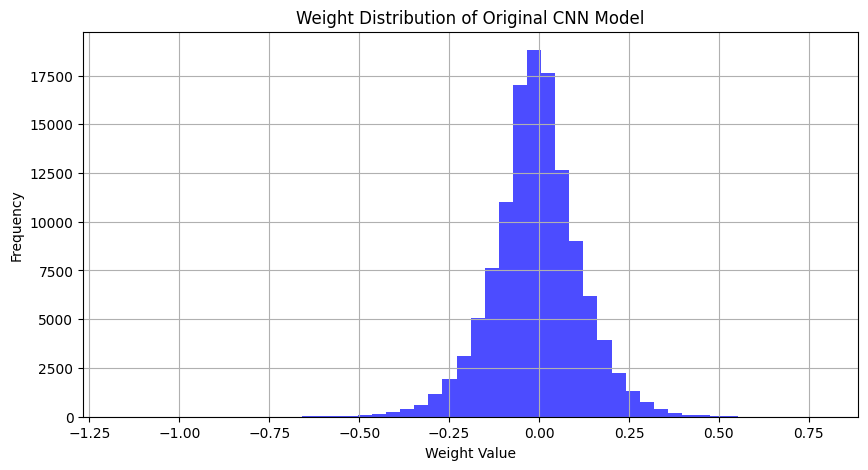

Skipping tensor with index 10 due to ValueError.
Skipping tensor with index 11 due to ValueError.
Skipping tensor with index 12 due to ValueError.
Skipping tensor with index 13 due to ValueError.
Skipping tensor with index 14 due to ValueError.
Skipping tensor with index 15 due to ValueError.


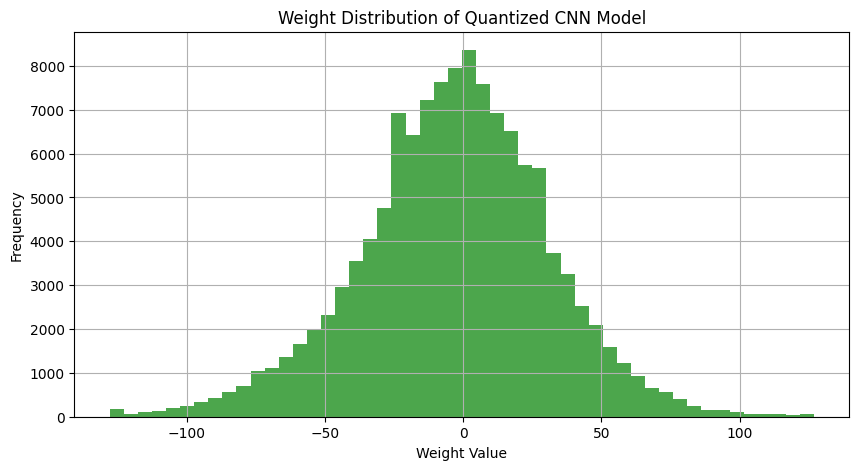

In [49]:
# Graph of the distribution of weights in a Keras model
def plot_weight_distribution(model, title):
    weights = model.get_weights()
    all_weights = np.concatenate([w.flatten() for w in weights])

    plt.figure(figsize=(10, 5))
    plt.hist(all_weights, bins=50, alpha=0.7, color='blue')
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the weight distribution of the original CNN model
plot_weight_distribution(model_cnn, 'Weight Distribution of Original CNN Model')

# The TFLite interpreter object cannot use get_weights()
# Plot the weight distribution of the quantized CNN model
# Load the quantized model weights from the file
interpreter_cnn_quantized = tf.lite.Interpreter(model_path=str(quantized_tflite_model_cnn_path))
interpreter_cnn_quantized.allocate_tensors()

# Extract weights from the quantized model
quantized_weights = []
for tensor in interpreter_cnn_quantized.get_tensor_details():
    if tensor['dtype'] == np.int8 and tensor['index'] >= 0:  # Check if the tensor is of type int8 (quantized weights)
        try:
            quantized_weights.append(interpreter_cnn_quantized.get_tensor(tensor['index']))
        except ValueError:
            # Skip tensors that cannot be retrieved
            print(f"Skipping tensor with index {tensor['index']} due to ValueError.")

# Check if quantized_weights is not empty before concatenating
if quantized_weights:
    all_quantized_weights = np.concatenate([w.flatten() for w in quantized_weights])
else:
    all_quantized_weights = np.array([])  # Handle the case where no weights are found

# Plot the weight distribution of the quantized CNN model
plt.figure(figsize=(10, 5))
plt.hist(all_quantized_weights, bins=50, alpha=0.7, color='green')
plt.title('Weight Distribution of Quantized CNN Model')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()